In [2]:
# For the UFS-MRW simulationsimport xarray as xr
import itertools
import logging
import math
import os
import pdb
import pickle
import re
import warnings
from datetime import datetime, timedelta
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy
import numpy as np
import pandas as pd
import pygrib
import shapely.geometry as sgeom
import xarray
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from cartopy.geodesic import Geodesic
from cartopy.util import add_cyclic_point
from matplotlib import ticker
from matplotlib.path import Path as mPath
from metpy.calc import dewpoint_from_relative_humidity, specific_humidity_from_dewpoint
from metpy.units import units
from shapely.geometry import Point, Polygon
from sklearn.neighbors import BallTree as SKBallTree

warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")


# relative_humidity_from_specific_humidity(1013.25 * units.hPa, 30 * units.degC, 18/1000).to('percent')

# from utils import na_values

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Read Lupo tracked cut-off low information (obtained from D. Ahijevych)

na_values = {
    "ID": -1,
    "ZMIN(m)": -9999.90,
    "ZLAT(N)": -9999.90,
    "ZLON(E)": -9999.90,
    "DY(km)": -9999.90,
    "DX(km)": -9999.90,
    "DIST(km)": -9999.90,
    "MAXDUR(h)": -9999.90,
    "PTY-OVR": 9999.90,
    "FERRY(km)": -99999.90,
    "FERRX(km)": -99999.90,
    "FERR(km)": -99999.90,
    "VLat(N)": -9999.90,
    "VLon(E)": -9999.90,
    "VSo": -9999.90,
    "VRo": -9999.90,
    "VZmin": -9999.90,
}

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Code from Dave Ahijeviych


def tissot(ax: plt.axes, df: pd.DataFrame, **kwargs) -> None:
    """
    Author: Dave Ahijeviych
    Draw circle with Ro(km) radius around (LON(E), LAT(N)).
    Color is in "color" column.

    Parameters
    ----------
    ax : plt.axes
        axes to draw on
    df : pd.DataFrame
        DataFrame with these columns
            Ro(km)
            LON(E)
            LAT(N)
            color

    Returns
    -------
    None
    """

    for i, row in df.iterrows():
        t = ax.tissot(
            rad_km=row["Ro(km)"],
            lons=row["LON(E)"],
            lats=row["LAT(N)"],
            # color=row["color"],
            # color='r',
            **kwargs,
        )
    return


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  This creates a geodesic circle
#  May Wong


def create_geodesic_circle(lat, lon, radius):
    # convert radius from input (km) to meters

    gd = Geodesic()
    cp = gd.circle(lon=lon, lat=lat, radius=radius * 1000.0)

    # This is long-lat coordinate system for use in ..
    # .. coordinate transformation options
    src_crs = ccrs.PlateCarree()

    # Show example
    # fig = plt.figure(figsize=(7,7))
    # ax = fig.add_subplot(111, projection=src_crs)
    # ax.coastlines(resolution='50m')
    # geoms = []
    # geoms.append(sgeom.Polygon(cp))
    # ax.add_geometries(geoms, crs=src_crs, edgecolor='r', alpha=0.5)
    # plt.show()

    return cp


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  This creates a mask based on the xlat, xlon polygon
#  May Wong


def create_mask_with_coords(coords, xlat, xlon):
    # coords is the coordinates of the polygon shape (e.g., using create_geodesic_circle)

    # MATPLOTLIB CONTAINS_POINTS METHOD TO CREATE A MASK
    x = xlon.flatten()
    y = xlat.values.flatten()
    points = np.vstack((x, y)).T

    p = mPath(coords)  # e.g., GEODESIC CIRCLE
    grid = p.contains_points(points)
    mask = grid.reshape(xlon.shape[0], xlon.shape[1])
    # plt.contourf(xlon,xlat,mask)
    # plt.colorbar()
    return mask


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Load the cutoff low objects based on the run initialization time
# May Wong


def load_col_obj(itime):
    workdir = Path("/glade/derecho/scratch/ahijevyc/ks21_tmp/")

    sdate = itime.strftime("%Y%m%d%H")
    files = workdir.glob(sdate + "/diag_TroughsCutoffs.??????????.f???.track")
    df = pd.DataFrame()
    for f in files:
        # print(f)
        df = pd.concat(
            [
                df,
                pd.read_csv(
                    f,
                    header=0,
                    sep=r"\s+",
                    na_values=na_values,
                ),
            ]
        )
    return df


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def loadobs_col_obj(valid_time):
    obs_path = valid_time.strftime(
        "/glade/u/home/klupo/work_new/postdoc/kasugaEA21/version9/HGT_500mb/"
        f"gfs.0p25.%Y%m%d%H.f000.track"
    )
    obs = pd.read_csv(
        obs_path,
        header=0,
        sep=r"\s+",
        na_values=na_values,
    )
    return obs


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# . Adapted from Dave A. code
# This gets the list of initializatin times for the specific forecast lengths (h)


def get_init_times(casedir, forecast_length):
    isensemble = False
    # Choose a forecast length (24, 48, 72, or 240 work for deterministic fcsts)
    forecast_length = 192 if isensemble else forecast_length

    datepos = 0
    cases = sorted(casedir.glob(f"[12]?????????.F{forecast_length:03d}.C768"))
    if isensemble:
        assert forecast_length in [
            192,
            120,
        ], f"unexpected ensemble forecast_length {forecast_length}"
        cases = sorted(casedir.glob(f"E[12]?????????.p??.F{forecast_length:03d}.C768"))
        datepos = 1

    # set extent
    lon0 = -131
    lon1 = -48
    lat0 = 23
    lat1 = 65

    fmt = "%Y%m%d%H"
    itimes = [pd.to_datetime(c.name[datepos : datepos + 10], format=fmt) for c in cases]
    print(f"found {len(itimes)} itimes with {forecast_length}-h forecasts in casedir {casedir}")

    # Choose an initialization time index
    # 10 in Lupo2023
    # itimes_index = 10
    # itimes_index = itimes.index(pd.to_datetime("20200409T12")-pd.to_timedelta(forecast_length, "hour"))
    # logging.info(f"chose itime={itimes[itimes_index]}")

    pd.Series(itimes, name="itime")
    return itimes, cases


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Given a 2D field and an object record (lat,lon center and radius (km)),
# computes the domain average.
def get_domave(field, xlon, xlat, record, scaleRo, clevels):
    if record["ITIME"].shape[0] != 1:
        print(
            "Too many cut-off lows selected. Try reducing the number of cutoff lows or region of interest."
        )
        return
    else:
        lat_record = record["LAT(N)"].values[0]
        lon_record = record["LON(E)"].values[0]
        Ro_record = record["Ro(km)"].values[0] * scaleRo
        # print(lat_record, lon_record, Ro_record)

        pts = create_geodesic_circle(lat_record, lon_record, Ro_record)
        binary_field = create_mask_with_coords(pts, xlat, xlon)

        if len(field.shape) == 3:  # if 3D field
            binary_field_3d = np.zeros(field.shape, dtype=bool)
            binary_field_3d[:, :, :] = binary_field[:, :]
            newX = np.ma.array(field, mask=~binary_field_3d)

            mean_val = np.mean(np.mean(newX, axis=1), axis=1)
            return mean_val
        elif len(field.shape) == 2:  # if 2D field
            newX = np.ma.array(field, mask=~binary_field)
            mean_val = np.mean(newX)
            return mean_val
        else:
            print("get_domave: Invalid dimensions for input 'field'. STOP.")
            return
        # print("Mean = "+str(mean_val))

        # print("Plotting COL of interest and field.")

        # clim1 = np.min(newX)
        # clim2 = np.max(newX)

        # Plot the COLs of interest
        # fig = plt.figure(figsize=(11,6))

        # ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
        # #plt.contourf(xlon,xlat,newX,np.linspace(clim1,clim2,20),transform=ccrs.PlateCarree(),cmap='bwr')
        # plt.contourf(xlon,xlat,newX,clevels,transform=ccrs.PlateCarree(),cmap='bwr')
        # #plt.contourf(xlon,xlat,field2d,clevels,transform=ccrs.PlateCarree(),cmap='bwr')

        # ax.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
        # lon_formatter = cticker.LongitudeFormatter()
        # ax.xaxis.set_major_formatter(lon_formatter)

        # # Latitude labels
        # ax.set_yticks(np.arange(-90,91,15), crs=ccrs.PlateCarree())
        # lat_formatter = cticker.LatitudeFormatter()
        # ax.yaxis.set_major_formatter(lat_formatter)

        # # Add coastlines
        # ax.coastlines()
        # ax.gridlines()
        # ax.set_extent([360.+min_lon, 360.+max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
        # ax.set_title( record['ITIME'].values[0])

        # plt.colorbar()


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# FUNCTION TO GRAB A SINGLE GFS LEVEL GIVEN A VALID TIME
# TODO: use utils.get_obsds
def get_GFS_analyses_single_level(YYYYMMDDHH, level):
    # YYYYMMDDHH is the valid time in UTC
    # varname is one of (TMP, RH, HGT)
    # levels is the list of pressure levels (in hPa) -- only provide one

    # print("Using get_GFS_analyses_single_level(YYYYMMDDHH, varname, level) -- this returns an xrarray")
    gfs_prefix = "/glade/derecho/scratch/mwong/UFS-MRW/GFS_ANL/gfs.0p25." + YYYYMMDDHH
    fldtmp = None
    if len(level) != 1:
        print("Too many input levels. Reduce to size 1. Stop.")
        return

    for k, level in enumerate(level):
        fn = gfs_prefix + "." + str(level) + "mb.nc"
        ds_f000 = xr.open_dataset(fn, engine="netcdf4")

    return ds_f000


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# FUNCTION TO GRAB ALL GFS LEVELS GIVEN A VALID TIME
# TODO: use utils.get_obsds. It sorts lat and lon too.
def get_GFS_analyses_all_levels(YYYYMMDDHH, varname, levels):
    # YYYYMMDDHH is the valid time in UTC
    # varname is one of (TMP, RH, HGT)
    # levels is the list of pressure levels (in hPa)

    gfs_prefix = "/glade/derecho/scratch/mwong/UFS-MRW/GFS_ANL/gfs.0p25." + YYYYMMDDHH
    fldtmp = None
    for k, level in enumerate(levels):
        varname_level = varname + "_" + str(level) + "mb"

        fn = gfs_prefix + "." + str(level) + "mb.nc"
        ds_f000 = xr.open_dataset(fn, engine="netcdf4")

        # for checking if order of longitudes is the same as the interpolated UFS output
        tmp = ds_f000[varname_level].longitude.values
        larray = tmp > 180
        tmp[larray] = tmp[larray] - 360.0
        gfslon = np.zeros(shape=tmp.shape)
        gfslon[0:719] = tmp[721:]
        gfslon[720:] = tmp[0:720]

        tmp = ds_f000[varname_level][0, :, :]  # .values
        if fldtmp is None:
            dims = [len(levels), tmp.shape[0], tmp.shape[1]]
            fldtmp = np.zeros(shape=dims)
        fldtmp[k, :, 0:719] = tmp[:, 721:]
        fldtmp[k, :, 720:] = tmp[:, 0:720]
        fldtmp[k, :, :] = fldtmp[k, ::-1, :]  # flip along y-axis (latitude values)

    return fldtmp


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# FUNCTION to convert RH to specific humidity (kg/kg)
def convert_rh_to_spfh(TMP, RH, plev):
    # INPUTS:
    #    - TMP is the temperature field (2D or 3D)
    #    - RH is the relative humidity field (2D)
    #    - plev (hPa) is the pressure level at which the TMP and RH fields are on
    TMP_nlev = TMP.shape[0]
    RH_nlev = RH.shape[0]
    pres_nlev = len(plev)

    TMP_ndims = TMP.ndim
    RH_ndims = RH.ndim

    # check for shape consistency in input variables
    if TMP_ndims != RH_ndims:
        print("RH and TMP have different shapes. STOP.")
        return

    if TMP_ndims == 3 and RH_ndims == 3:
        if TMP_nlev != RH_nlev or TMP_nlev != pres_nlev:
            print(
                "TMP, RH, and/or pressure levels do not have the same number of levels. STOP."
            )
            print(str(TMP_nlev) + ",  " + str(RH_nlev) + ",  " + str(pres_nlev))
            return
    elif TMP_ndims == 2 and RH_ndims == 2:
        if pres_nlev != 1:
            print("Too many input pressure levels. 2D TMP and RH fields were found. STOP.")
            print(str(TMP_ndims) + ",  " + str(RH_ndims) + ",  " + str(pres_nlev))
            return

    # convert RH to dew point
    dptanl = dewpoint_from_relative_humidity(TMP * units.K, RH * units.percent)
    spfhanl = np.zeros(shape=dptanl.shape)

    if len(plev) > 1:
        # print("More than one pressure level found")
        for k, pres in enumerate(plev):
            spfhanl[k, :, :] = specific_humidity_from_dewpoint(
                pres * units.hPa, dptanl[k, :, :]
            ).to("kg/kg")
        return spfhanl
    else:
        spfhanl = specific_humidity_from_dewpoint(plev * units.hPa, dptanl).to("kg/kg")
        return spfhanl


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# FUNCTION to process valid time based on record information (for the cut-off low)
def get_validtime_object(record_row):
    tval = record_row["ITIME"].values
    tval = tval[0].astype(str)
    tobj = datetime.strptime(tval, "%Y%m%d%H")

    fhval = record_row["FHOUR"].values
    fhval = fhval[0]
    fhval = int(fhval.split("f")[1])
    return tobj + timedelta(hours=fhval)


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def flip_londim(fld):
    fldtmp = fld.copy()

    if len(fldtmp.shape) == 3:
        fld = np.zeros(shape=fldtmp.shape)

        fld[:, :, 0:719] = fldtmp[:, :, 721:]
        fld[:, :, 720:] = fldtmp[:, :, 0:720]
        return fld
    elif len(fldtmp.shape) == 2:
        fld[:, 0:719] = fldtmp[:, 721:]
        fld[:, 720:] = fldtmp[:, 0:720]
        return fld
    else:
        print("flip_londim: invalid dimensions. STOP.")
        return


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def xtime(ds: xarray.Dataset):
    """convert xtime variable to datetime and assign to coordinate"""

    # remove one-element-long Time dimension
    ds = ds.squeeze(dim="Time", drop=True)

    logging.info("decode initialization time variable")
    Time = pd.to_datetime(
        ds["Times"].load().item().decode("utf-8").strip(),
        format="%Y-%m-%d_%H:%M:%S",
    )

    # assign initialization time variable to its own coordinate
    ds = ds.assign_coords(
        Time=(
            ["Time"],
            [Time],
        ),
    )
    return ds


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# FUNCTION to get the list of tendency components
def list_components(fld):
    if fld == "dt3dt":
        tendlist = [
            "deepcnv",
            "mp",
            "nonphys",
            "pbl",
            "shalcnv",
            "cnvgwd",
            "lw",
            "sw",
            "rdamp",
            "ogwd",
        ]
    elif fld == "dq3dt":
        tendlist = ["deepcnv", "mp", "nonphys", "pbl", "shalcnv"]

    return tendlist


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

parallel = False
if parallel:
    try:
        client.cluster.close()
        client.shutdown()
        client.close()
    except:
        pass

    from dask.distributed import Client

    client = Client(n_workers=8)
    client


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#
# Function to plot the polar map given a lat/lon center and a radius.
#
def draw_polar_map(global_data_2D, latc, lonc, radius, is_anl: bool):
    # INPUT variables: latc = latitude of center point (degs)
    #                  lonc = longitude of center point (degs - can be negative)
    #                  radius = radius to plot

    # Convert longitude of center positive value
    if lonc < 0:
        lonc = lonc + 360.0

    # Set up the sub-domain to plot
    minx = lonc - radius
    maxx = lonc + radius
    miny = latc - radius
    maxy = latc + radius

    # GFS analyses and UFS-MRW forecasts are processed slightly differently due to lat/lon variable conventions
    if is_anl:
        boxdata = global_data_2D.sel(longitude=slice(minx, maxx), latitude=slice(miny, maxy))
        boxlon, boxlat = boxdata.longitude, boxdata.latitude
    elif is_anl == False:
        # for forecasts that have 2D XLAT, XLONG arrays
        XLAT = global_data_2D["XLAT"][:, 0].values
        XLONG = global_data_2D["XLONG"][0, :].values
        XLONG = np.where(XLONG < 0, XLONG + 360.0, XLONG)
        indices = np.where(((XLAT >= miny) & (XLAT <= maxy)))
        boxdata = global_data_2D.isel(
            south_north=np.arange(np.min(indices), np.max(indices) + 1)
        )
        indices = np.where(((XLONG >= minx) & (XLONG <= maxx)))
        boxdata = boxdata.isel(west_east=np.arange(np.min(indices), np.max(indices) + 1))

        boxlon, boxlat = boxdata.XLONG, boxdata.XLAT

    # Plotting test data on the Cartesian grid (mostly for debugging)
    # fig, ax = plt.subplots()
    # plt.pcolormesh( boxlon, boxlat, boxdata, cmap='gist_ncar' )
    # plt.colorbar()

    # convert lat/lon to radians for calculations
    boxlat = np.radians(boxlat)
    boxlon = np.radians(boxlon)
    latc = np.radians(latc)
    lonc = np.radians(lonc)

    # Using lat/lon distance
    if False:
        numerator = np.cos(boxlat) * np.sin(boxlon - lonc)
        denominator = np.cos(latc) * np.sin(boxlat) - np.sin(latc) * np.cos(boxlat) * np.cos(
            boxlon - lonc
        )
        theta = np.arctan2(numerator, denominator)
        theta = theta.where(
            theta.values > 0,
            theta.values + 2 * math.pi,
        )
        R = 1.0
        cosr = np.sin(latc) * np.sin(test_lat) + np.cos(latc) * np.cos(test_lat) * np.cos(
            test_lon - lonc
        )
        r = np.arccos(cosr / R)

        fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
        cs = ax.contourf(theta, r, test_data, cmap="bwr")  # , levels=np.linspace(5540,5810,60))
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)  # theta increasing clockwise
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_ylim([0, np.max(r)])
        cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
        fig.colorbar(cs, cax=cbaxes)

    # Using Cartesian distance
    if True:
        # define x,y based on distance (in degrees) from center
        inc = (2 * radius) / boxdata.shape[0]
        x = np.linspace(-radius, radius + inc, boxdata.shape[0] + 1)
        y = np.linspace(-radius, radius + inc, boxdata.shape[1] + 1)
        [xmesh, ymesh] = np.meshgrid(x, y)

        # calculate polar coordinates (r, theta)
        r = np.sqrt(np.power(xmesh, 2) + np.power(ymesh, 2))
        theta = np.arctan2(ymesh, xmesh)
        theta = np.where(theta < 0, theta + 2 * np.pi, theta)

        fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

        if is_anl == False:
            boxdata = np.flipud(boxdata)

        cs = ax.pcolormesh(theta, r, boxdata, cmap="seismic", vmin=-2, vmax=2)
        # ax.contour(theta[:-1,:-1], r[:-1,:-1], boxdata, colors='k',linestyles='dashed')
        ax.yaxis.set_tick_params(labelleft=False)
        cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
        fig.colorbar(cs, cax=cbaxes)
        ax.set_ylim([0, radius])
        # print(ax.get_xticklabels())
        # ax.set_xticklabels(['90°'])
        ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
        # ax.set_xticklabels(['N', '', 'W', '', 'S', '', 'E', ''])
        return ax, theta, r, boxdata


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#
# Function to get the polar map cut-out data, along with polar coordinate info
#
def cutout_polar_map(global_data_2D, latc, lonc, radius, is_anl: bool):
    # INPUT variables: latc = latitude of center point (degs)
    #                  lonc = longitude of center point (degs - can be negative)
    #                  radius = radius to plot

    # Convert longitude of center positive value
    if lonc < 0:
        lonc = lonc + 360.0

    # Set up the sub-domain to plot
    minx = lonc - radius
    maxx = lonc + radius
    miny = latc - radius
    maxy = latc + radius

    # GFS analyses and UFS-MRW forecasts are processed slightly differently due to lat/lon variable conventions
    if is_anl:
        boxdata = global_data_2D.sel(longitude=slice(minx, maxx), latitude=slice(miny, maxy))
        boxlon, boxlat = boxdata.longitude, boxdata.latitude
    elif is_anl == False:
        # for forecasts that have 2D XLAT, XLONG arrays
        XLAT = global_data_2D["XLAT"][:, 0].values
        XLONG = global_data_2D["XLONG"][0, :].values
        XLONG = np.where(XLONG < 0, XLONG + 360.0, XLONG)
        indices = np.where(((XLAT >= miny) & (XLAT <= maxy)))
        boxdata = global_data_2D.isel(
            south_north=np.arange(np.min(indices), np.max(indices) + 1)
        )
        indices = np.where(((XLONG >= minx) & (XLONG <= maxx)))
        boxdata = boxdata.isel(west_east=np.arange(np.min(indices), np.max(indices) + 1))

        boxlon, boxlat = boxdata.XLONG, boxdata.XLAT

    # Plotting test data on the Cartesian grid (mostly for debugging)
    # fig, ax = plt.subplots()
    # plt.pcolormesh( boxlon, boxlat, boxdata, cmap='gist_ncar' )
    # plt.colorbar()

    # convert lat/lon to radians for calculations
    # REPEATED???????????????????
    boxlat = np.radians(boxlat)
    boxlon = np.radians(boxlon)

    # Plotting test data on the Cartesian grid (mostly for debugging)
    # fig, ax = plt.subplots()
    # plt.pcolormesh( boxlon, boxlat, boxdata, cmap='gist_ncar' )
    # plt.colorbar()

    # convert lat/lon to radians for calculations
    boxlat = np.radians(boxlat)
    boxlon = np.radians(boxlon)
    latc = np.radians(latc)
    lonc = np.radians(lonc)

    # Using Cartesian distance
    if True:
        # define x,y based on distance (in degrees) from center
        inc = (2 * radius) / boxdata.shape[0]
        x = np.linspace(-radius, radius + inc, boxdata.shape[0] + 1)
        y = np.linspace(-radius, radius + inc, boxdata.shape[1] + 1)
        [xmesh, ymesh] = np.meshgrid(x, y)

        # calculate polar coordinates (r, theta)
        r = np.sqrt(np.power(xmesh, 2) + np.power(ymesh, 2))
        theta = np.arctan2(ymesh, xmesh)
        theta = np.where(theta < 0, theta + 2 * np.pi, theta)

        if is_anl == False:
            boxdata = np.flipud(boxdata)

        return theta, r, boxdata

In [3]:
# *********************************************
#
# START LOADING THE FORECAST(S) OF INTEREST
#
# *********************************************v

casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")

forecast_length = 72

itimes, cases = get_init_times(casedir, forecast_length)
print(itimes)
print(len(cases))

found 24 itimes with 72-h forecasts in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw
[Timestamp('2019-10-23 06:00:00'), Timestamp('2019-11-24 06:00:00'), Timestamp('2019-12-20 00:00:00'), Timestamp('2020-02-09 06:00:00'), Timestamp('2020-02-20 12:00:00'), Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-06 12:00:00'), Timestamp('2020-04-09 12:00:00'), Timestamp('2020-05-16 12:00:00'), Timestamp('2020-08-29 18:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-25 18:00:00'), Timestamp('2020-11-25 06:00:00'), Timestamp('2021-03-14 18:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-11 12:00:00'), Timestamp('2021-04-28 06:00:00'), Timestamp('2021-10-16 18:00:00'), Timestamp('2021-10-26 06:00:00'), Timestamp('2021-12-31 06:00:00'), Timestamp('2022-02-13 12:00:00'), Timestamp('2022-04-11 06:00:00'), Timestamp('2022-05-02 12:00:00'), Timestamp('2022-06-11 18:00:00')]
24


In [4]:
%%time

if forecast_length == 240:
    forecast_length = 96

fn = (
    "/glade/derecho/scratch/mwong/UFS-MRW/TENDS_pickles/DS_F"
    + str(forecast_length).zfill(3)
    + "_over_18h.pkl"
)

if Path(fn).is_file():
    with open(fn, "rb") as data:
        [ds, ds_p] = pickle.load(data)
else:
    # LOAD THE FORECAST FILES BASED ON FORECAST LEAD TIME (defined by "forecast_length")
    cases_selected = cases  # [0:2] #[0:24]

    # Look at Day 4 from 10-day forecasts
    if forecast_length == 240:
        forecast_length = 96

    listoffiles = []
    for case in cases_selected:
        ifiles = (case / "interp").glob(
            "interp_fv3_history2d_??????????_f" + str(forecast_length).zfill(3) + ".nc"
        )
        # ifiles = list(ifiles)
        listoffiles.append(list(ifiles)[0])
    print(listoffiles)

    ds = xarray.open_mfdataset(
        listoffiles, preprocess=xtime, parallel=True, compat="override", coords="minimal"
    )

    logging.warning(f"opened {len(listoffiles)} files")
    logging.info(ifiles)

    # now also load the 18h previous files to get the tendencies over that 18-h period
    listoffiles = []
    for case in cases_selected:
        ifiles = (case / "interp").glob(
            "interp_fv3_history2d_??????????_f" + str(forecast_length - 18).zfill(3) + ".nc"
        )
        # ifiles = list(ifiles)
        listoffiles.append(list(ifiles)[0])
    print(listoffiles)

    ds_p = xarray.open_mfdataset(
        listoffiles, preprocess=xtime, parallel=True, compat="override", coords="minimal"
    )

    logging.warning(f"opened {len(listoffiles)} files")
    logging.info(ifiles)

    # SAVE THE DATASET IN A PICKLE FILE
    with open(fn, "wb") as output:
        pickle.dump([ds, ds_p], output)

CPU times: user 2.53 s, sys: 330 ms, total: 2.86 s
Wall time: 3.15 s


In [5]:
# GRAB LAT/LON VALUES

levels = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100]

print(ds["dt3dt500_deepcnv"].XLAT)
xlat = ds["dt3dt500_deepcnv"].XLAT
xlontmp = ds["dt3dt500_deepcnv"].XLONG
xlon = np.zeros(shape=xlontmp.shape)
xlon[:, 0:719] = xlontmp[:, 721:]
xlon[:, 720:] = xlontmp[:, 0:720]

<xarray.DataArray 'XLAT' (south_north: 721, west_east: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north
    MemoryOrder:  XY
    stagger:      
    FieldType:    104


In [6]:
# # ...... TEST - creating mask for computing domain averages
# pts = create_geodesic_circle(30., -105., 600.)
# #poly = Polygon(pts)
# binary_field = create_mask_with_coords( pts, xlat, xlon)
# plt.contourf(xlon,xlat,binary_field)

In [7]:
# Loading COL objects
print(len(itimes))
dfcol = pd.DataFrame()
for i in np.arange(0, len(cases)):
    dfload = load_col_obj(itimes[i])
    dfcol = pd.concat([dfcol, dfload])
print(dfcol)

24
         ITIME FHOUR       ID  So(m/100km)  LAT(N)  LON(E)  SoFlag  Ro(km)  \
0   2019102306  f006  32359.0        13.41   79.50  149.25       0   700.0   
1   2019102306  f006  32328.0        12.95   73.25  228.50       0   700.0   
2   2019102306  f006  32343.0        17.37   68.75  349.25       1   500.0   
3   2019102306  f006  32309.0        19.28   62.75   51.00       0   500.0   
4   2019102306  f006  32370.0        11.10   59.50  107.75       0   600.0   
..         ...   ...      ...          ...     ...     ...     ...     ...   
38  2022061118  f006  52008.0        12.35  -66.25  308.25       0   600.0   
39  2022061118  f006  52001.0        26.25  -67.75  271.50       0   500.0   
40  2022061118  f006  51980.0        13.62  -68.75  156.00       0   500.0   
41  2022061118  f006  51981.0        23.79  -74.50  191.50       0   300.0   
42  2022061118  f006      NaN        17.28  -81.50  240.00      -1   400.0   

      SR  BGo(m/100km)  ...  PTY-OVR  FERRY(km)  FERRX(km)  

In [8]:
# FIRST, FIND THE COL OF INTEREST

# set domain of interest to limit the number of COL to average over
min_lat = 10.0
max_lat = 45.0
min_lon = -120.0
max_lon = -80.0
df = dfcol
Ro_lim = 2500.0

print("Filtering by forecast_length = " + str(forecast_length))

# Filter by location
record = df[
    (df["FHOUR"] == "f" + str(forecast_length).zfill(3))
    & (df["LAT(N)"] >= min_lat)
    & (df["LAT(N)"] <= max_lat)
    & (df["LON(E)"] <= max_lon + 360.0)
    & (df["LON(E)"] >= min_lon + 360.0)
]

# Filter by object size
record = record[record["Ro(km)"] <= Ro_lim]

# Drop repeated IDs (keep the first entry)
record = record.drop_duplicates(subset=["ID"], keep="first")

# Filter by date also
record = record[record["ITIME"] == 2020040612]

print("Number of COLs found: " + str(len(record)))

Filtering by forecast_length = 72
Number of COLs found: 1


In [9]:
# ******************************************************************************************
#
# Counting number of COL in analyses and then match ID to the forecast objects
# ******************************************************************************************

count = 0

record_obs_save = pd.DataFrame()
record_fcst_save = pd.DataFrame()

for col_index in np.arange(0, len(record)):
    record_row = record.iloc[[col_index]]
    validtime = get_validtime_object(record_row)

    df_obs = loadobs_col_obj(validtime)
    record_obs = df_obs[
        (df_obs["LAT(N)"] >= min_lat)
        & (df_obs["LAT(N)"] <= max_lat)
        & (df_obs["LON(E)"] <= max_lon + 360.0)
        & (df_obs["LON(E)"] >= min_lon + 360.0)
    ]
    record_obs = record_obs[record_obs["Ro(km)"] <= Ro_lim]
    # print(record_obs)

    if ~np.isnan(record_row["ID"].values):
        if len(record_obs) > 1:
            for i in np.arange(0, len(record_obs)):
                if record_obs.iloc[[i]]["ID"].values == record_row["ID"].values:
                    count = count + 1
                    # print(str(count)+" Found match ID: "+str(int(record_obs.iloc[[0]]["ID"]))+"  "+str(int(record_row["ID"])))
                    record_obs_save = pd.concat([record_obs_save, record_obs.iloc[[i]]])
                    record_fcst_save = pd.concat([record_fcst_save, record_row])
                # else:
                #    print("Unmatched. Skip: "+str(int(record_obs.iloc[[0]]["ID"]))+"  "+str(int(record_row["ID"])))
        else:
            if record_obs["ID"].values == record_row["ID"].values:
                count = count + 1
                # print(str(count)+" Found match ID: "+str(int(record_obs["ID"]))+"  "+str(int(record_row["ID"])))
                record_obs_save = pd.concat([record_obs_save, record_obs])
                record_fcst_save = pd.concat([record_fcst_save, record_row])
            # else:
            #  print("Unmatched. Skip: "+str(int(record_obs["ID"]))+"  "+str(int(record_row["ID"])))

print("Number of observed COLs found: " + str(len(record_obs_save)))
print("Number of forecast COLs matched: " + str(len(record_fcst_save)))

Number of observed COLs found: 1
Number of forecast COLs matched: 1


In [10]:
# **********************************************************************************************************
#
# Compute the composite of only the tendencies
#
# **********************************************************************************************************
reload = True
ufsfld = "dq3dt"
scope_radius = 45
shape_r = 361

# get the list of tendency components
tendlist = list_components(ufsfld)


if reload:
    # the initialization times for all the found COLs
    strtime = record_fcst_save["ITIME"].values
    tind = 0
    save_tind = 0

    mean_polar_ufs = np.zeros(shape=(len(tendlist), len(levels), shape_r, shape_r))
    count = 0  # reset counter of objects

    # Composite over all objects found for the forecast lead time
    for col_index in np.arange(0, len(record_fcst_save)):
        print("COL index : " + str(col_index))

        # forecast object
        record_row = record_fcst_save.iloc[[col_index]]
        print(record_row["ID"])
        print(record_row["LAT(N)"])

        # get valid time for the cut-off low forecast object
        valid_timeobject = get_validtime_object(record_row)

        # get COL object in analysis that matches the forecast object ID
        record_obs = record_obs_save[record_obs_save["ID"].values == record_row["ID"].values]

        # find the matching forecasts (in time)
        for i in np.arange(save_tind, len(itimes)):  # all the possible initial times
            itimes_str = itimes[i].strftime("%Y%m%d%H")
            ind = np.where(strtime[col_index] == int(itimes_str))

            # search for matching time
            if ind[0].size > 0 and ind[0] == 0:
                tind = i
                save_tind = tind
                break

        # loop through all vertical levels
        for k, sel_lev in enumerate(levels):
            # forecast variable
            for tnum, tendname in enumerate(tendlist):
                field = ufsfld + str(sel_lev) + "_" + tendname

                # forecast field to composite
                fld = ds[field][tind, :, :] - ds_p[field][tind, :, :]

                # Only get the data near the cut-off low object
                # To plot, use draw_polar_map instead.

                theta, r, circdata_ufs = cutout_polar_map(
                    fld,
                    record_row["LAT(N)"].values[0],
                    record_row["LON(E)"].values[0],
                    scope_radius,
                    False,
                )  # (data, latc, lonc, radius in degrees)
                mean_polar_ufs[tnum, k, :, :] = mean_polar_ufs[tnum, k, :, :] + circdata_ufs

                # print("Added valid time = "+(itimes[tind]+timedelta(hours=forecast_length)).strftime('%Y%m%d%H') )

        count = count + 1

    print("Composited over " + str(count) + " COL events")
    mean_polar_ufs = mean_polar_ufs / count

print(forecast_length)

# -----------------------------
# Save the data
if forecast_length == 240:
    forecast_length = 96

if False:
    fn = (
        "/glade/derecho/scratch/mwong/UFS-MRW/TENDS_pickles/COMPOSITE_MEAN_QTEND_COMPONENTS_F"
        + str(forecast_length).zfill(3)
        + "_over_18h.pkl"
    )
    print(fn)
    if Path(fn).is_file():
        with open(fn, "rb") as data:
            [forecast_length, r, theta, levels, mean_polar_ufs] = pickle.load(data)
    else:
        # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
        # RUN THE COMPUTE COMPOSITE BLOCK OF CODE FIRST
        # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

        # SAVE THE DATASET IN A PICKLE FILE
        with open(fn, "wb") as output:
            pickle.dump([forecast_length, r, theta, levels, mean_polar_ufs], output)

COL index : 0
17    35563.0
Name: ID, dtype: float64
17    35.5
Name: LAT(N), dtype: float64


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_56254/2189268202.py:42: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  ind = np.where(strtime[col_index] == int(itimes_str))


Composited over 1 COL events
72


-0.01307257916778326
0.0047946227714419365


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_56254/3705772233.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])


72
-0.011485246941447258
0.01273895800113678


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_56254/3705772233.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])


72
-0.00749296834692359
0.009757193736732006


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_56254/3705772233.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])


72
-0.00273400591686368
0.01261112466454506


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_56254/3705772233.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])


72
-0.0010907198302447796
0.0012181432684883475


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_56254/3705772233.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])


72


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_56254/3705772233.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])


Text(0.5, 1.0, 'UFS 72-h fcst composite - sum of tends')

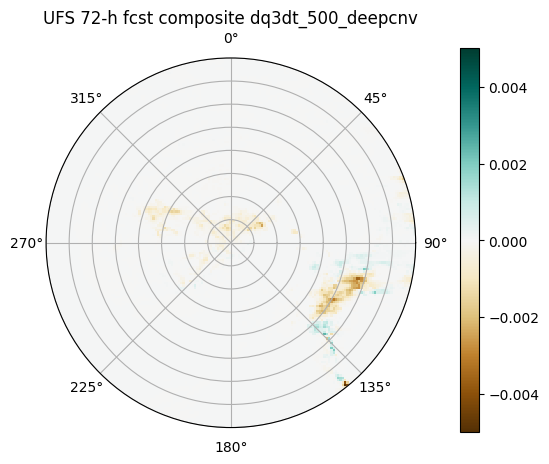

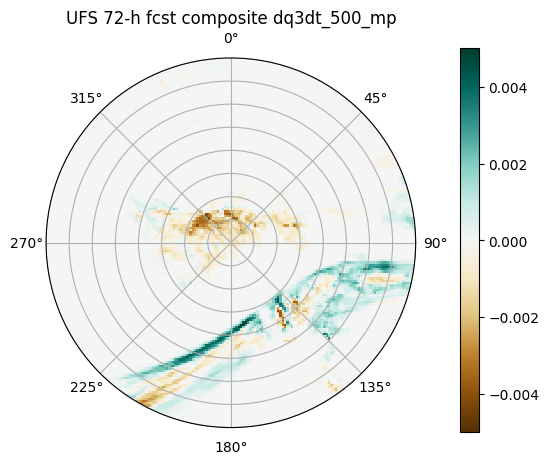

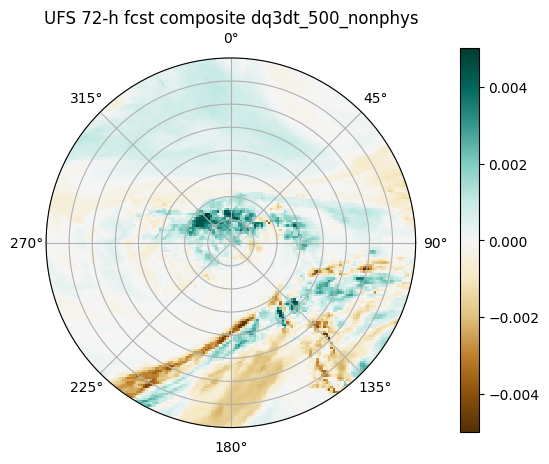

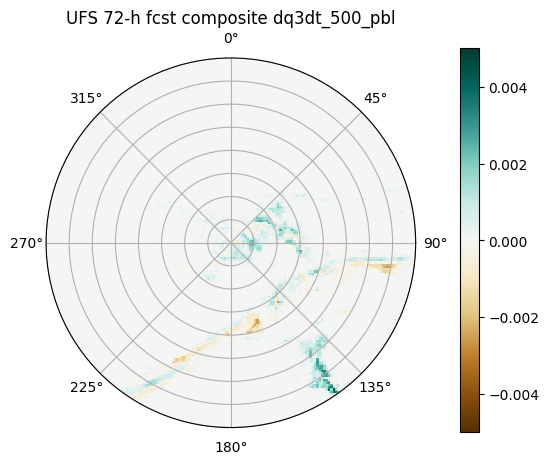

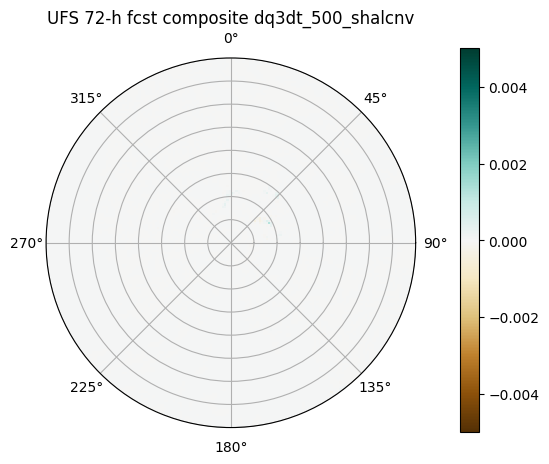

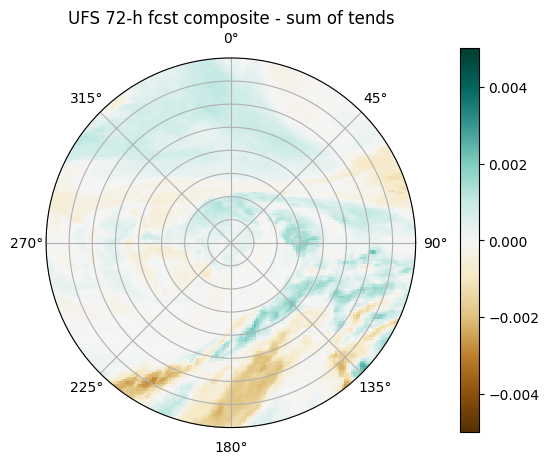

In [11]:
# *** PLOT THE MEAN POLAR MAPS
climit = 0.005
scope_radius_plot = 20
lev2plt = levels.index(500)

# get the list of tendency components
ufsfld = "dq3dt"
tendlist = list_components(ufsfld)

local_sum = np.zeros(shape=(361, 361))

for tend2plt, tendcomp in enumerate(tendlist):
    # for tendnum in np.arange(0,1):
    # tend2plt = tendlist.index('nonphys')
    # tendcomp = tendlist[tend2plt]

    tendname = "dq3dt_" + str(levels[lev2plt]) + "_" + tendcomp

    # Choose a different forecast lead time if desired
    for forecast_length in [72]:
        if False:
            fn = (
                "/glade/derecho/scratch/mwong/UFS-MRW/TENDS_pickles/COMPOSITE_MEAN_QTEND_COMPONENTS_F"
                + str(forecast_length).zfill(3)
                + "_over_18h.pkl"
            )
            print(fn)

            if Path(fn).is_file():
                with open(fn, "rb") as data:
                    [forecast_length, r, theta, levels, mean_polar_ufs] = pickle.load(data)
            else:
                print("Cannot find file.")

        # This plots the mean:
        print(np.min(mean_polar_ufs[tend2plt, lev2plt, :, :]))
        print(np.max(mean_polar_ufs[tend2plt, lev2plt, :, :]))
        fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
        cs = ax.pcolormesh(
            theta,
            r,
            mean_polar_ufs[tend2plt, lev2plt, :, :],
            cmap="BrBG",
            vmin=-climit,
            vmax=climit,
        )
        local_sum = local_sum + mean_polar_ufs[tend2plt, lev2plt, :, :]

        ax.set_ylim([0, scope_radius_plot])
        ax.yaxis.set_tick_params(labelleft=False)
        cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
        fig.colorbar(cs, cax=cbaxes)
        ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
        ax.set_title(
            "UFS " + str(forecast_length) + "-h fcst composite " + tendname
        )  # composite tendencies')
        plt.savefig("UFS" + str(forecast_length) + "h_" + tendname + ".png")
    # Sometimes I forget which forecast hour we are looking at
    print(forecast_length)


# Plot sum of tendencies
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
cs = ax.pcolormesh(theta, r, local_sum[:, :], cmap="BrBG", vmin=-climit, vmax=climit)
ax.set_ylim([0, scope_radius_plot])
ax.yaxis.set_tick_params(labelleft=False)
cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
fig.colorbar(cs, cax=cbaxes)
ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
ax.set_title(
    "UFS " + str(forecast_length) + "-h fcst composite - sum of tends"
)  # composite tendencies')

['deepcnv', 'mp', 'nonphys', 'pbl', 'shalcnv']
-0.028229206800460815
0.004864179994910955
-0.005716181360185146
0.009818505495786667
-0.050541382282972336
0.018344489857554436
-0.018387462943792343
0.04756566137075424
-0.02702210284769535
0.013194140046834946


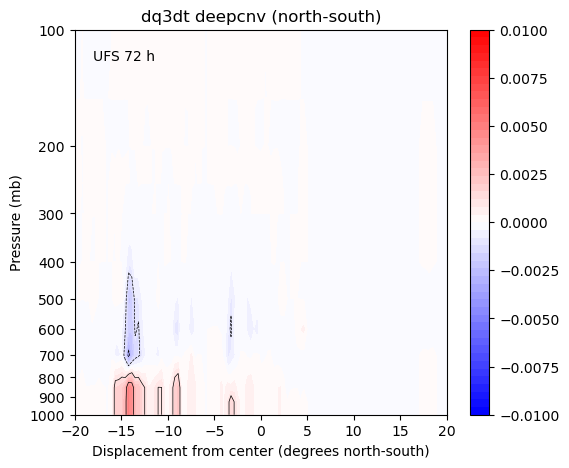

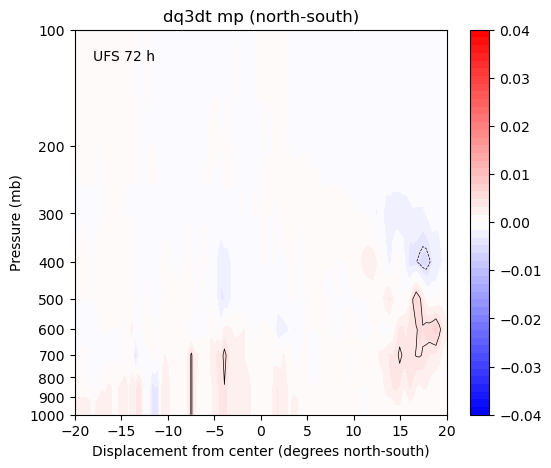

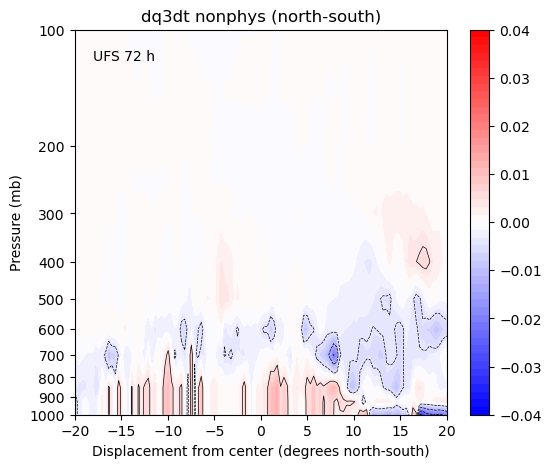

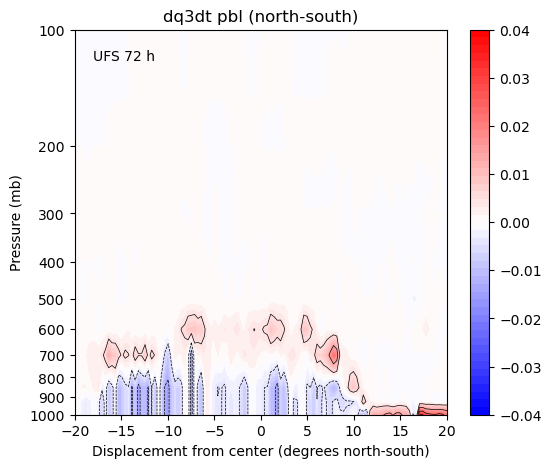

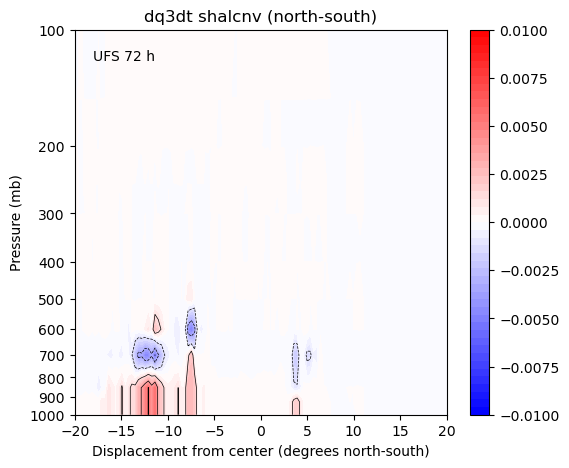

In [66]:
# Plot the vertical cross-sections (W-E or N-S)

# PuOr  for longwave
# RdYlBu for deepcnv
# RdBu for mp
# PiYG for dynamics

print(tendlist)
tend2pltlist = tendlist
# tend2pltlist = [ 'deepcnv', 'mp', 'nonphys' ]
# tend2pltlist = [ 'deepcnv' ,'lw' ,'mp', 'nonphys' ]
# tend2pltlist = [ 'pbl', 'shalcnv', 'cnvgwd', 'ogwd', 'rdamp']
for tname in tend2pltlist:
    tend2plt = tendlist.index(tname)
    tendcomp = tendlist[tend2plt]
    MIN, MAX = -0.04, 0.04
    selcmap = "bwr"
    if tname == "deepcnv":
        MIN, MAX = -1e-2, 1e-2
    elif tname == "shalcnv":
        MIN, MAX = -1e-2, 1e-2
    #     MIN, MAX = -4,4 # Color scale
    #     selcmap = 'RdYlBu_r'
    # elif ( tname == 'mp' ):
    # MIN, MAX = -5,5ax
    #     selcmap = 'RdBu_r'
    # elif ( tname == 'lw' ):
    #     MIN, MAX = -3,3
    #     selcmap = 'PuOr_r'
    # elif ( tname == 'nonphys'):
    #     MIN, MAX = -12,12
    #     selcmap = 'PiYG_r'
    # elif ( tname == 'pbl'):
    #     MIN,MAX = -12,12
    #     selcmap = 'RdBu_r'
    # elif ( tname == 'shalcnv' ):
    #     MIN,MAX = -3, 3
    #     selcmap = 'RdBu_r'
    # elif ( tname == 'cnvgwd' ):
    #     MIN,MAX = -0.01, 0.01
    #     selcmap = 'RdBu_r'
    # else:
    #     MIN,MAX = -0.4, 0.4
    #     selcmap = 'RdBu_r'

    for forecast_length in [72]:
        if forecast_length == 240:
            forecast_length = 96

        if False:
            fn = (
                "/glade/derecho/scratch/mwong/UFS-MRW/TENDS_pickles/COMPOSITE_MEAN_QTEND_COMPONENTS_F"
                + str(forecast_length).zfill(3)
                + "_over_18h.pkl"
            )
            print(fn)
            if Path(fn).is_file():
                with open(fn, "rb") as data:
                    [forecast_length, r, theta, levels, mean_polar_ufs] = pickle.load(data)
            else:
                # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
                # RUN THE COMPUTE COMPOSITE BLOCK OF CODE FIRST
                # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

                # SAVE THE DATASET IN A PICKLE FILE
                print("Run the compute composite block first!")

        # ------------------------------------------------------------------------------------
        #
        # Make vertical cross-sections of composite means
        #
        # ------------------------------------------------------------------------------------

        # # This plots the mean on the horizontal plane -- sanity checks.
        # scope_radius_plot = 45
        # fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
        # cs = ax.pcolormesh(theta, r, mean_polar_ufs[5,:,:], cmap='seismic', vmin=-climit, vmax=climit)
        # ax.set_ylim([0,scope_radius_plot])
        # ax.yaxis.set_tick_params(labelleft=False)
        # cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
        # fig.colorbar(cs, cax=cbaxes)
        # ax.set_xticklabels(['90°', '45°', '0°', '315°', '270°', '225°', '180°', '135°'])
        # ax.set_title('UFS 24-h fcst composite tendencies')

        ufs = True
        gfs = False

        west_east = False
        north_south = True
        fig, ax = plt.subplots(figsize=(6, 5))
        radlim = 20  # radius to plot

        [xmesh, zmesh] = np.meshgrid(np.linspace(-np.max(r), np.max(r), len(r[0, :-1])), levels)

        if ufs:
            fld = mean_polar_ufs[tend2plt, :, :, :]
            label_in_plot = "UFS " + str(forecast_length) + " h"
        elif gfs:
            fld = mean_polar_gfs
            label_in_plot = "GFS analysis"

        if north_south:
            print(np.min(np.fliplr(fld[:, :, 180])))
            print(np.max(np.fliplr(fld[:, :, 180])))
            cf = plt.contourf(
                xmesh, zmesh, np.fliplr(fld[:, :, 180]), np.linspace(MIN, MAX, 51), cmap=selcmap
            )
            plt.contour(
                xmesh,
                zmesh,
                np.fliplr(fld[:, :, 180]),
                np.linspace(MIN, MAX, 10),
                colors="k",
                linewidths=0.5,
            )
            plt.title(ufsfld + " " + tname + " (north-south)")
            plt.xlabel("Displacement from center (degrees north-south)")
        elif west_east:
            print(np.min(fld[:, 180, :]))
            print(np.max(fld[:, 180, :]))

            cf = plt.contourf(
                xmesh, zmesh, fld[:, 180, :], np.linspace(MIN, MAX, 51), cmap=selcmap
            )
            plt.contour(
                xmesh,
                zmesh,
                fld[:, 180, :],
                np.linspace(MIN, MAX, 10),
                colors="k",
                linewidths=0.5,
            )
            plt.title(ufsfld + " " + tname + " (west-east)")
            plt.xlabel("Displacement from center (degrees west-east)")

        ax.set_yscale("log")
        plt.ylim([np.min(levels), np.max(levels)])
        plt.ylim([400, 600])
        plt.yticks(np.arange(100, 1100, 100))
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        plt.gca().invert_yaxis()
        plt.ylabel("Pressure (mb)")

        plt.xlim([-radlim, radlim])
        cbar = plt.colorbar(cf)
        cblim = MAX
        if cblim >= 10:
            cbint = 2.0
        elif cblim <= 1.0:
            cbint = cblim / 4.0
        else:
            cbint = 1.0
        cbar.set_ticks(np.arange(-cblim, cblim + cbint, cbint))
        plt.text(-radlim + 2, 120, label_in_plot)

        if west_east:
            plt.savefig("west_east_" + str(forecast_length) + "h_accumulated_" + tname + ".png")
        elif north_south:
            plt.savefig(
                "north_south_" + str(forecast_length) + "h_accumulated_" + tname + ".png"
            )

In [ ]:
# **********************************************************************************************************
#
# Plot the composites
#
# **********************************************************************************************************
reload = True
sel_lev = 200  # choose pressure level
field = "t" + str(sel_lev)
gfsfld = "TMP"
scope_radius = 45
shape_r = 361

if reload:
    # Create an xarray to store the composite fields
    ds = ds.assign(meanfld_ufs=ds[field][0, :, :] * 1.0)
    ds["meanfld_ufs"][:, :] = 0.0

    tind = 0
    ds1 = get_GFS_analyses_single_level(
        (itimes[tind] + timedelta(hours=forecast_length - 18)).strftime("%Y%m%d%H"), [sel_lev]
    )

    dsmean = ds1.copy()
    dsmean = dsmean.assign(
        meanfld_gfs=dsmean[gfsfld + "_" + str(sel_lev) + "mb"][0, :, :] * 1.0
    )
    dsmean["meanfld_gfs"][:, :] = 0.0

    #####
    strtime = record_fcst_save[
        "ITIME"
    ].values  # the initialization times for all the found COLs
    tind = 0
    save_tind = 0
    count = 0
    mean_polar_gfs = np.zeros(shape=(shape_r, shape_r))
    mean_polar_ufs = np.zeros(shape=(shape_r, shape_r))
    for col_index in np.arange(0, len(record_fcst_save)):
        print("COL index : " + str(col_index))

        record_row = record_fcst_save.iloc[[col_index]]

        # get valid time for the cut-off low object
        valid_timeobject = get_validtime_object(record_row)

        # get COL object in analysis that matches the forecast object ID
        record_obs = record_obs_save[record_obs_save["ID"].values == record_row["ID"].values]

        # Get GFS analysis fields to get the domain averages over the object
        # anl_tmp2 = get_GFS_analyses_all_levels( valid_timeobject.strftime('%Y%m%d%H'), 'TMP', levels)
        # anl_tmp1 = get_GFS_analyses_all_levels( (valid_timeobject - timedelta(hours=18)).strftime('%Y%m%d%H'), 'TMP', levels)

        # find the matching forecasts
        for i in np.arange(save_tind, len(itimes)):  # all the possible initial times
            itimes_str = itimes[i].strftime("%Y%m%d%H")
            ind = np.where(strtime[col_index] == int(itimes_str))

            # search for matching time
            if ind[0].size > 0 and ind[0] == 0:
                tind = i
                save_tind = tind
                break

        # get the forecast composite
        fld = ds[field][tind, :, :] - ds_p[field][tind, :, :]
        ds["meanfld_ufs"] = ds["meanfld_ufs"] + fld

        # get analysis composite
        ds1 = get_GFS_analyses_single_level(
            (itimes[tind] + timedelta(hours=forecast_length - 18)).strftime("%Y%m%d%H"),
            [sel_lev],
        )
        ds2 = get_GFS_analyses_single_level(
            (itimes[tind] + timedelta(hours=forecast_length)).strftime("%Y%m%d%H"), [sel_lev]
        )
        gfs_fld = (
            ds2[gfsfld + "_" + str(sel_lev) + "mb"][0, :, :]
            - ds1[gfsfld + "_" + str(sel_lev) + "mb"][0, :, :]
        )
        dsmean["meanfld_gfs"] = dsmean["meanfld_gfs"] + gfs_fld

        # Make plots
        # ax_obs, theta, r, circdata_obs = draw_polar_map( ds2[gfsfld+'_'+str(sel_lev)+'mb'][0,:,:]-ds1[gfsfld+'_'+str(sel_lev)+'mb'][0,:,:], record_obs['LAT(N)'].values[0], record_obs['LON(E)'].values[0], scope_radius, True) # (data, latc, lonc, radius in degrees)
        # ax_ufs, theta, r, circdata_ufs = draw_polar_map( fld, record_row['LAT(N)'].values[0], record_row['LON(E)'].values[0], scope_radius, False) # (data, latc, lonc, radius in degrees)
        # Just get the data near the cut-off low object
        theta, r, circdata_obs = cutout_polar_map(
            ds2[gfsfld + "_" + str(sel_lev) + "mb"][0, :, :]
            - ds1[gfsfld + "_" + str(sel_lev) + "mb"][0, :, :],
            record_obs["LAT(N)"].values[0],
            record_obs["LON(E)"].values[0],
            scope_radius,
            True,
        )  # (data, latc, lonc, radius in degrees)
        theta, r, circdata_ufs = cutout_polar_map(
            fld,
            record_row["LAT(N)"].values[0],
            record_row["LON(E)"].values[0],
            scope_radius,
            False,
        )  # (data, latc, lonc, radius in degrees)

        mean_polar_gfs = mean_polar_gfs + circdata_obs.values
        mean_polar_ufs = mean_polar_ufs + circdata_ufs

        # ax_obs.set_title('GFS analysis valid at '+(itimes[tind]+timedelta(hours=forecast_length)).strftime('%Y%m%d%H'))
        # ax_ufs.set_title('UFS 48-h fcst valid at '+(itimes[tind]+timedelta(hours=forecast_length)).strftime('%Y%m%d%H'))

        print(
            "Added valid time = "
            + (itimes[tind] + timedelta(hours=forecast_length)).strftime("%Y%m%d%H")
        )
        count = count + 1

    print("Compositing over " + str(count) + " COL events")
    ds["meanfld_ufs"] = ds["meanfld_ufs"] / count
    dsmean["meanfld_gfs"] = dsmean["meanfld_gfs"] / count

    mean_polar_gfs = mean_polar_gfs / count
    mean_polar_ufs = mean_polar_ufs / count

# *** PLOT THE POLAR MAPS ***


# *** PLOT THE MEAN POLAR MAPS
climit = 5
scope_radius = 20

# This plots the mean:
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
cs = ax.pcolormesh(theta, r, mean_polar_gfs, cmap="seismic", vmin=-climit, vmax=climit)
ax.set_ylim([0, scope_radius])
ax.yaxis.set_tick_params(labelleft=False)
cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
fig.colorbar(cs, cax=cbaxes)
ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
ax_obs.set_title("GFS analysis composite tendencies")

# This plots the mean:
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
cs = ax.pcolormesh(theta, r, mean_polar_ufs, cmap="seismic", vmin=-climit, vmax=climit)
ax.set_ylim([0, scope_radius])
ax.yaxis.set_tick_params(labelleft=False)
cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
fig.colorbar(cs, cax=cbaxes)
ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
ax_ufs.set_title("UFS 24-h fcst composite tendencies")

print(forecast_length)

In [ ]:
%%time
# **********************************************************************************************************
# Compute the domain-averaged vertical profiles using the matched forecast and analysis objects (ID)
#
# **********************************************************************************************************

s = np.zeros(shape=(len(record_fcst_save), len(levels)))
g = np.zeros(shape=(len(record_fcst_save), len(levels)))
field = "t500"
tind = 0
fld = np.zeros(
    shape=[len(levels), ds[field][tind, :, :].shape[0], ds[field][tind, :, :].shape[1]]
)


print(s.shape)
strtime = record_fcst_save["ITIME"].values  # the initialization times for all the found COLs
save_tind = 0
for col_index in np.arange(0, len(record_fcst_save)):
    print("COL index : " + str(col_index))

    record_row = record_fcst_save.iloc[[col_index]]

    # get valid time for the cut-off low object
    valid_timeobject = get_validtime_object(record_row)

    # get COL object in analysis that matches the forecast object ID
    record_obs = record_obs_save[record_obs_save["ID"].values == record_row["ID"].values]

    # Get GFS analysis fields to get the domain averages over the object
    anl_tmp2 = get_GFS_analyses_all_levels(valid_timeobject.strftime("%Y%m%d%H"), "TMP", levels)
    anl_tmp1 = get_GFS_analyses_all_levels(
        (valid_timeobject - timedelta(hours=18)).strftime("%Y%m%d%H"), "TMP", levels
    )

    # anl_rh2 = get_GFS_analyses_all_levels( valid_timeobject.strftime('%Y%m%d%H'), 'RH', levels )
    # anl_rh1 = get_GFS_analyses_all_levels( (valid_timeobject - timedelta(hours=18)).strftime('%Y%m%d%H'), 'RH', levels)

    # anl_spfh2 = convert_rh_to_spfh( anl_tmp2[:,:,:], anl_rh2[:,:,:], levels)
    # anl_spfh1 = convert_rh_to_spfh( anl_tmp1[:,:,:], anl_rh1[:,:,:], levels)
    # print("Done converting")

    # find the matching forecasts
    for i in np.arange(save_tind, len(itimes)):  # all the possible initial times
        itimes_str = itimes[i].strftime("%Y%m%d%H")
        ind = np.where(strtime[col_index] == int(itimes_str))

        if ind[0].size > 0 and ind[0] == 0:
            tind = i
            save_tind = tind
            break

    # Scale the radius of the object
    scale_Ro = 0.5

    # #print( 'Processing COL_index : '+str(col_index))
    print(str(col_index) + "   Found time index = " + str(tind))

    for ik, l in enumerate(levels):
        field = "t" + str(l)
        fld[ik, :, :] = ds[field][tind, :, :]  # -ds_p[field][tind,:,:]
    fld = flip_londim(fld)
    s[col_index, :] = get_domave(
        fld, xlon, xlat, record_row, scale_Ro, np.linspace(-20, 20, 30)
    )

    fld = anl_tmp2  # - anl_tmp1
    # fld = anl_spfh2 - anl_spfh1
    g[col_index, :] = get_domave(
        fld, xlon, xlat, record_obs, scale_Ro, np.linspace(-20, 20, 30)
    )
    print("Done averaging. next")

In [292]:
import matplotlib.ticker as mticker

print(forecast_length)

print(np.min(s))
print(np.max(s))
# fig = plt.figure(figsize=(3,6))
fig = plt.figure(figsize=(3, 6))
plt.plot(np.transpose(s), levels, "c", alpha=0.5, linewidth=0.5, label="UFS-MRW")
plt.plot(np.transpose(g), levels, "k", alpha=0.5, linewidth=0.5, label="GFS analysis")


plt.plot(np.nanmean(np.transpose(s), axis=1), levels, "r-", linewidth=3.0)
plt.plot(np.nanmean(np.transpose(g), axis=1), levels, "k--", linewidth=2.0)
plt.gca().invert_yaxis()
ax = plt.gca()
clim = 0.002
# plt.xlim([-clim, clim])
plt.xlim([200, 300])
# plt.yticklabels(levels)
plt.yscale("log")
plt.yticks(levels)
plt.yscale("log")
plt.ylim([np.min(levels), np.max(levels)])
plt.yticks(np.arange(100, 1100, 100))
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.plot([0, 0], [np.min(levels), np.max(levels)], "k--", linewidth=1.0)
plt.gca().invert_yaxis()
# plt.xlabel('Spec. hum. change (kg/kg) over 18 h')
plt.ylabel("Pressure (hPa)")

24


NameError: name 's' is not defined

In [48]:
forecast_length

48

21     400.0
14     400.0
18     500.0
16     300.0
12     700.0
12    1300.0
18     500.0
25     700.0
22     500.0
15     300.0
14     500.0
17     400.0
19     200.0
20     500.0
20     300.0
17     400.0
19     500.0
19    1000.0
24     700.0
15     600.0
20    1000.0
19     300.0
20     600.0
17     300.0
19     200.0
Name: Ro(km), dtype: float64


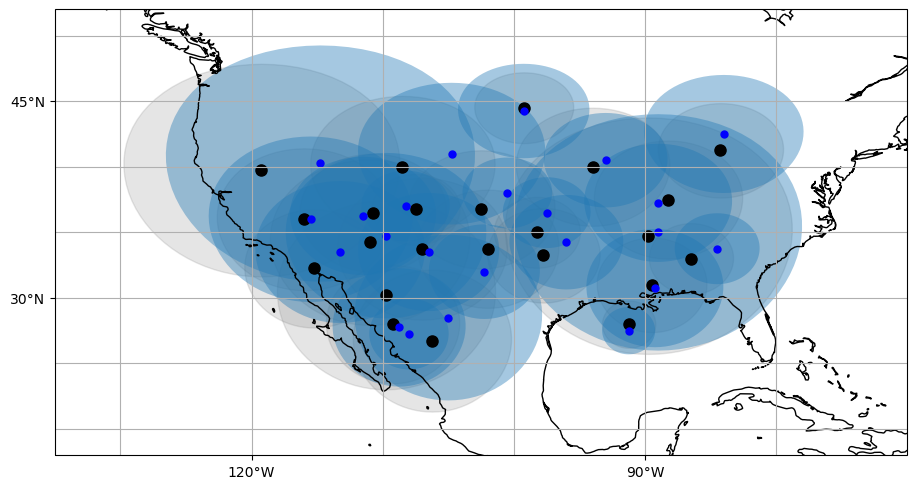

In [25]:
# Plot the COLs of interest
fig = plt.figure(figsize=(11, 6))

print(record["Ro(km)"])

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))


plt.plot(
    record_obs_save["LON(E)"],
    record_obs_save["LAT(N)"],
    "ko",
    transform=ccrs.PlateCarree(),
    markersize=8,
)
plt.plot(
    record_fcst_save["LON(E)"],
    record_fcst_save["LAT(N)"],
    "bo",
    transform=ccrs.PlateCarree(),
    markersize=5,
)

ts = tissot(ax, record_obs_save, alpha=0.2, color="grey")
ts = tissot(ax, record_fcst_save, alpha=0.4)  # , color='red')

ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax.set_yticks(np.arange(-90, 91, 15), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add coastlines
ax.coastlines()
ax.gridlines()
plot_min_lat = 18.0
plot_max_lat = 52.0
plot_min_lon = -135.0
plot_max_lon = -70.0
ax.set_extent([plot_min_lon, plot_max_lon, plot_min_lat, plot_max_lat], crs=ccrs.PlateCarree())

In [ ]:
# Composite ideas
#
# - Filter by radius size?
# - Composite with km x km as dimensions and then centered around the center of the COL object